## Imports

In [30]:
import cv2
from matplotlib import pyplot as plt
from Line import *
from sklearn.cluster import DBSCAN
import lane_detection
import lane_following
import numpy as np

## Helper Functions

In [31]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Read Image

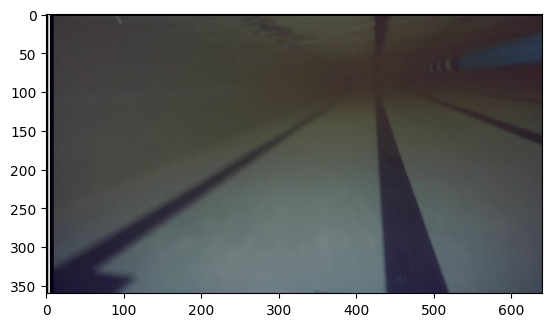

In [32]:
frame = cv2.imread("frames/frame35.jpg")
# frame = cv2.imread("frames/frame1260.jpg")
show(frame)

In [33]:
type(frame[0])

numpy.ndarray

## Slice Image

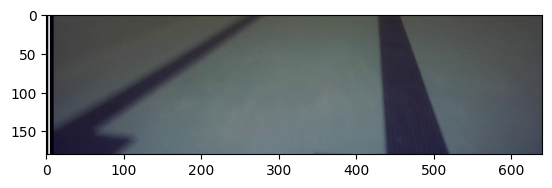

In [34]:
# sliced_frame = frame[ int(frame.shape[0] / 2) : frame.shape[0]]
sliced_frame = frame[int(frame.shape[0] / 2) : frame.shape[0]]
show(sliced_frame)

## Convert to Grayscale

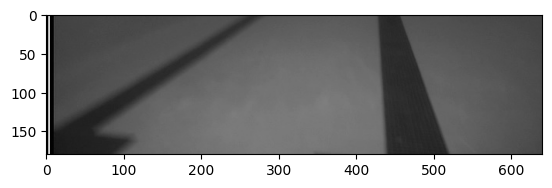

In [35]:
gray = cv2.cvtColor(sliced_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
show(gray)


## Blurring

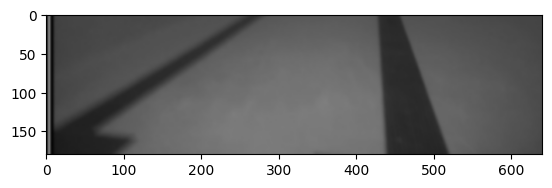

In [36]:
blur = cv2.GaussianBlur(gray, (7 , 7), 0)
show(blur)

## Black and White Conversion

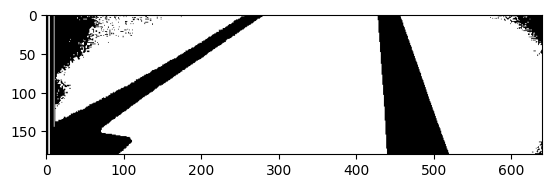

In [37]:
_, bw_image = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY)
show(bw_image)

## Edge Detection

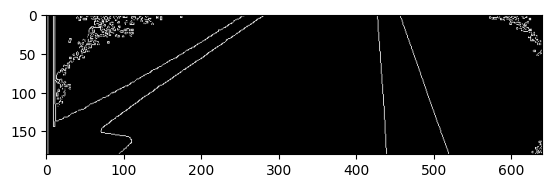

In [38]:
edges = cv2.Canny(
    bw_image, 50, 100, apertureSize=3
)  # detect edges
show(edges)


## Hough Lines to get Lines
Edge detection just highlights the edges, HoughLinesP gives us the points describing important edges

len(lines) = 12


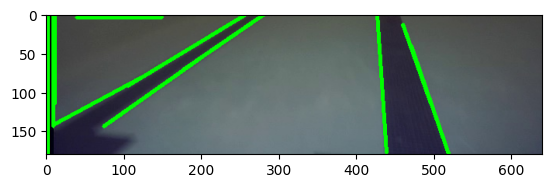

In [39]:
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi / 180,
    threshold=50,
    minLineLength=100,
    maxLineGap=20,
)  # detect lines

lines = [Line(line[0][0], line[0][1], line[0][2], line[0][3]) for line in lines]
# lines = lane_detection.merge_colinear_lines(lines)
print(f"{len(lines) = }")
drawn = lane_detection.draw_lines(sliced_frame, lines)

show(drawn)


## Group Lines by Slope
Using DBSCAN, group the lines

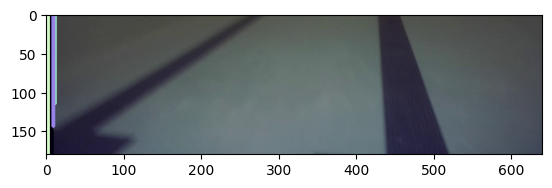

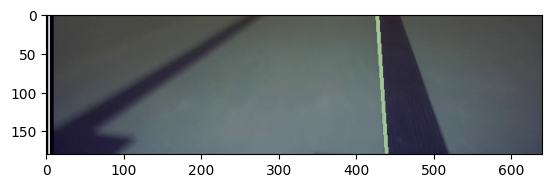

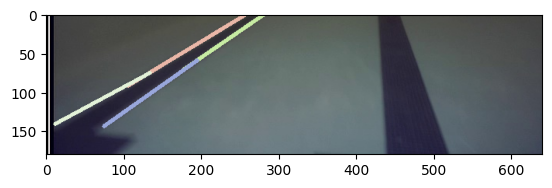

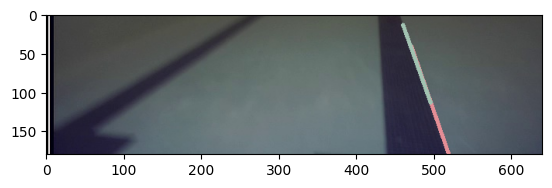

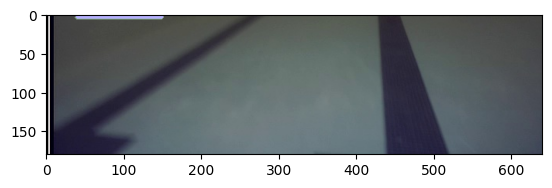

In [40]:
from lane_detection import draw_lines
slopes = [line.slope for line in lines]
slopes = np.array(slopes).reshape(-1, 1)  # convert slopes to a 2d array

slope_tolerance = 0.1
dbscan = DBSCAN(eps=slope_tolerance, min_samples=2)
labels = dbscan.fit_predict(slopes)  # labels is a list of clusters, basically

def group_data(labels: list[int], data: list[any]) -> dict[int, any]:
    """
    Group lines based on labels, which are expected to be the output of a DBSCAN fit.
    """
    grouped_data = {}
    for index, element in enumerate(data):
        label = labels[index]
        if label not in grouped_data:
            grouped_data[label] = []
        grouped_data[label].append(element)
        
    return grouped_data

grouped_lines = group_data(labels, lines)


for group in grouped_lines:
    show(draw_lines(sliced_frame, grouped_lines[group], random=True))
        

## Group and Combine Lines by X-Intercept
Now we have a dictionary pairing all of the lines with similar slopes together. However, this doesn't work great for all cases. Sometimes you have lines with similar slopes, but that are not actually colinear; that is, they are parallel but not intersecting. 
Because of such a case, we must first determine whether the lines share similar x-intercepts before we can merge them.

In [41]:
x_intercept_tolerance = 25
dbscan = DBSCAN(eps=x_intercept_tolerance, min_samples=2)
height = sliced_frame.shape[0]
for label, lines in grouped_lines.items():
    x_intercepts = [line.x(height/2) for line in lines]
    x_intercepts = np.array(x_intercepts).reshape(-1, 1)
    labels = dbscan.fit_predict(x_intercepts)
    grouped_lines[label] = group_data(labels, lines)    

### Test the X-intercept pairings

[1.9999999911, 10.9999999975, 8.9999999946]


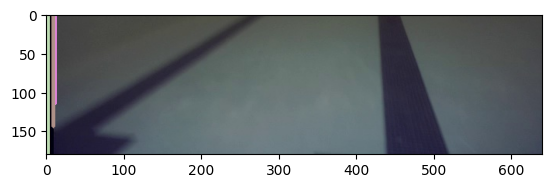

[433.0674157303371]


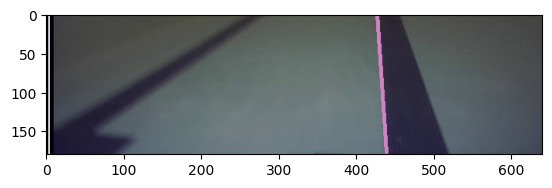

[149.16901408450704, 150.87058823529412]


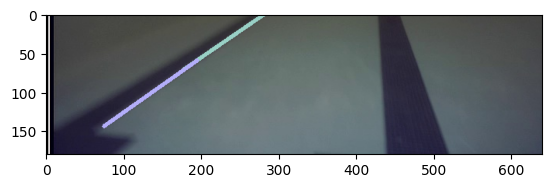

[108.31868131868131, 106.04545454545455]


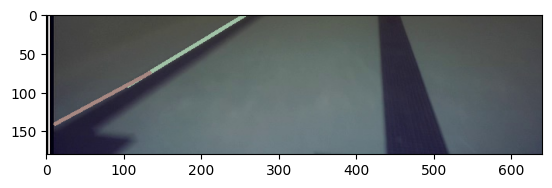

[488.04347826086956, 487.44554455445547]


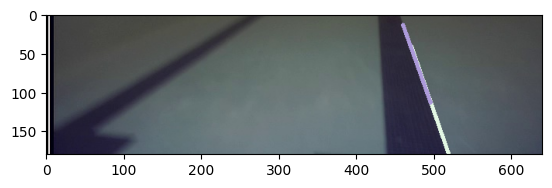

[8600000000000039.0, 8700000000000040.0]


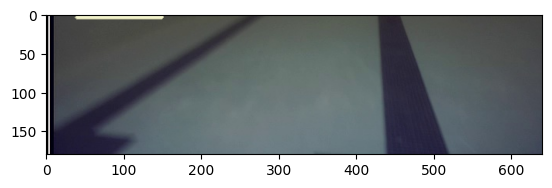

In [42]:
for _, slope_group in grouped_lines.items():
    for _, x_group in slope_group.items():
        print(f"{[line.x(height/2) for line in x_group]}")
        show(draw_lines(sliced_frame, x_group, random=True))

### Merge the Lines
Now that we finally have all of our lines split into appropriate groupings based on x-intercepts and slopes, we can merge each group.
This is done by collecting all of the x and y points of each group, and then taking the line of best fit in that group. This returns the slope and 
y-intercept of the line, $m$ and $b$.
The points of the new line are found using this form:
$(x_1, y_1), (x_2, y_2) = (0, b), (\text{width}, m * \text{width} + b)$

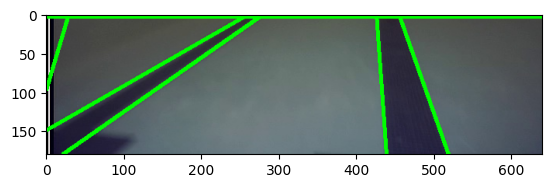

In [43]:
merged_lines = []
for _, slope_group in grouped_lines.items():
    for _, x_group in slope_group.items():
        # for each group, reset the x and y list
        x_list = []
        y_list = []
        # create a list of all the x and y coordinates in the group
        for line in x_group:
            x_list.extend([line.x1, line.x2])
            y_list.extend([line.y1, line.y2])
        m, b = np.polyfit(x_list, y_list, 1) # line of best fit for the points

        # y = mx + b
        # (y - b) / m = x
        height = sliced_frame.shape[0]
        width = sliced_frame.shape[1]
        y_list = [height, 0]
        x_list = [(y_list[0] - b) / m, (y_list[1] - b) / m] # (intercept with bottom of image, intercept with top)
        if x_list[0] < 0:
            x_list[0] = 0
            y_list[0] = b
        elif x_list[0] > width:
            x_list[0] = width
            y_list[0] = m * width + b
        merged_line = Line(x_list[0], y_list[0], x_list[1], y_list[1])
        merged_lines.append(merged_line)

merged_lines.sort(key=lambda x: x.x_intercept) # sort by x_intercept

show(draw_lines(sliced_frame, merged_lines))



In [44]:
for i, line in enumerate(merged_lines):
    print(line)

p1: (0, 3), p2: (84029, 0), slope: -0.00, x-intercept: -15041191.0, y-intercept: 3.0
p1: (0, 149), p2: (261, 0), slope: -0.57, x-intercept: -685.0, y-intercept: 149.0
p1: (21, 180), p2: (280, 0), slope: -0.69, x-intercept: -497.0, y-intercept: 194.59459459459458
p1: (0, 97), p2: (29, 0), slope: -3.34, x-intercept: -132.0, y-intercept: 97.0
p1: (439, 180), p2: (426, 0), slope: 13.85, x-intercept: 465.0, y-intercept: -5898.461538461539
p1: (519, 180), p2: (455, 0), slope: 2.81, x-intercept: 647.0, y-intercept: -1279.6875


## Lane Detection
This is perhaps the hardest part of the entire problem. You have a set of lines, hopefully a very accurate and brief one, and you need to pair them together. This is, however, very difficult. There are many, many cases. 
- If the lines are off to the side, their slopes will be parallel and x-intercepts similar; that should be easy. 
- When two lines are near the center, there is many more cases. Their slopes could be opposing, in which case they are pretty much lined up and can be easily paired. However, one of the lines could be nearly vertical, and therefore have a massive slope that is difficult to compare against.

The result is that all of the algorithms I have tried thus far have been very inaccurate; they are the product of overfitting. 
Tomorrow, I intend on trying to solve the lane detection problem in a different way: pixel detection. Not sure how exactly that is going to work yet, but here is the general idea:
1. Pick a pair of 2 lines with similar x-intercepts ($\pm$ 200?) and ensure that neither line has yet been paired
2. Find the average color of the 5-10 pixels between them
3. If:
    1. the color is black (or > than some threshold), then they are a lane; append and break
    2. the color is white (< than some threshold), then they aren't a lane; go back to step 1

#### Pixel Detection Algorithm
Given two points, how do you find the pixels between them?
$p_1 = (x_1, y_1)$ and $p_2 = (x_2, y_2)$. The image is a matrix with `height` rows and `width` columns. You can find a particular pixel by specifying the exact coordinates, like `img[y][x]` (I think). So for `x` in range($|x_1 - x_2|$) and `y` in range($|y_1 - y_2|$), add the pixel's color value and increment the pixel counter. Then, if the average pixel value is greater than some threshold, return true.


In [45]:
def dist(a, b):
    return abs(a - b)

In [46]:
def pixels_between(img, p1: tuple[int, int], p2: tuple[int, int]):
    """
    Returns the average color of the pixels between point 1 and point 2.
    """
    # we will index by pixels, so make sure they are within the confines of the image
    x_list = np.clip([p1[0], p2[0]], 0, img.shape[1] - 1)
    y_list = np.clip([p1[1], p2[1]], 0, img.shape[0] - 1)
    x_list.sort()
    y_list.sort()
    
    pixel_count = 0
    pixel_value = 0
    if y_list[0] == y_list[1]: # horizontal line
        for x in range(x_list[0], x_list[1]):
            pixel_value += img[y_list[0]][x]
            pixel_count += 1
            
    elif x_list[0] == x_list[1]: # vertical line
        for y in range(y_list[0], y_list[1]):
            pixel_value += img[y][x_list[0]]
            pixel_count += 1
    else:
        # line is neither vertical nor horizontal, so just return None
        return None
    average_value = pixel_value / pixel_count
    return average_value



In [47]:
from itertools import combinations

def detect_lanes(lines, img):
    lines.sort(key=lambda x: x.x_intercept)
    
    lanes = []
    for (line1, line2) in combinations(lines, 2):
        if line1.is_paired() or line2.is_paired():
            continue
        if dist(line1.x_intercept, line2.x_intercept) < 300 or dist(line1.y_intercept, line2.y_intercept) < 300:
            # line1, line2 is a fair candidate, next check the pixels between
            if pixels_between(img, (line1.x1, line1.y1), (line2.x1, line2.y1)) < 10:
                line1.paired = True
                line2.paired = True
                lanes.append((line1, line2))

    return lanes

In [48]:
from random import randrange
lanes = detect_lanes(merged_lines, bw_image)
img = sliced_frame.copy()
for lane in lanes:
    img = draw_lines(img, lane, color=(randrange(255), randrange(255), randrange(255)))
show(img)


TypeError: '<' not supported between instances of 'NoneType' and 'int'

## Lane Picking and Following
Now that we have our lanes determined, we need to find the lane which is closest to the center and then follow it.
This can be broken up into a few steps:
### Merge Lane Lines
Combine the lines of the lane to produce a center line for each lane.

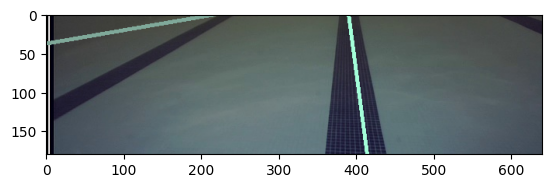

In [ ]:
center_lines = []
for lane in lanes:
    center_lines.append(Line(
        (lane[0].x_intercept + lane[1].x_intercept) / 2, 
        height, 
        (lane[0].x(0) + lane[1].x(0)) / 2, 
        0))

show(draw_lines(sliced_frame, center_lines, random = True))
    

### Pick the Center Lane
The center lane is the one that has an x-intercept closest to the center of the image, or `image_width / 2`. 

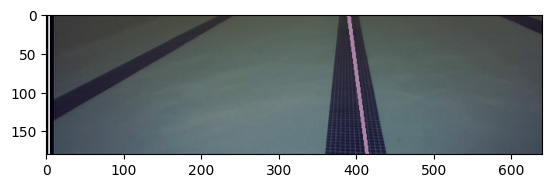

In [ ]:
def closest(lst, k):
    
    x = np.asarray([line.x_intercept for line in lst])
    idx = (np.abs(x - k)).argmin()
    return lst[idx]

closest_line = closest(center_lines, width/2)
show(draw_lines(sliced_frame, [closest_line], random = True))


### Suggest Direction
Based on the slope and x-intercept of the lane chosen as center, suggest whether the AUV needs to turn and which direction to move in.
Naively, if the center is on the left of the image, return left, if middle, return forward, and if right, return right.
Angle suggestion is much harder. Perhaps I could just find the angle of the slope and suggest that, at least to start..

In [ ]:
forward_tol = 50
mid = width / 2
mid_left = mid - forward_tol
mid_right = mid + forward_tol
x_intercept = closest_line.x_intercept
slope = closest_line.slope

if x_intercept > mid_right:
    # the lane center is right of the middle,
    strafe_direction = "right"

elif x_intercept < mid_left:
    # the lane center is left of the middle
    strafe_direction = "left"

else:
    # the lane center is in the middle region
    strafe_direction = "forward"

if 1/slope > 0:
    turn = "left"
if 1/slope < 0:
    turn = "right"

print(f"The AUV should move {strafe_direction} and turn {turn}")


The AUV should move left and turn right


In [ ]:

# cap = cv2.VideoCapture('AUV_Vid.mkv')

# count = 0 # the number of frames since the last
# frequency = 60 # the number of frames to skip

# while cap.isOpened():
#     ret, frame = cap.read()
#     if count % frequency == 0:
#         cv2.imwrite(f"./frames/frame{count}.jpg", frame)
#         # plt.imshow(cv2.cvtColor(render_frame(frame), cv2.COLOR_BGR2RGB))
#         # plt.show()
        
#     count += 1

0.0


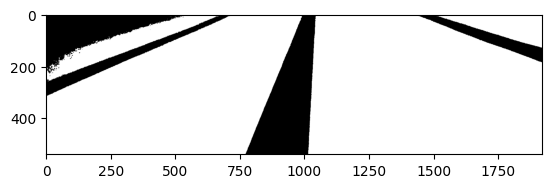

In [ ]:
from skimage.draw import line
cc, rr = line(800, 539, 1000, 539)
test = bw_image.copy()
s = np.sum(test[rr, cc])
c = np.ma.count(test[rr, cc])
print(s / c)
show(test)